# Predicting travel duration

In [15]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Loading data

In [8]:
df = pd.read_parquet('../data/yellow_tripdata_2022-01.parquet')
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


### Q1

In [9]:
len(df.columns)

19

## Data preprocessing

In [14]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60.0)
df.duration.describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

### Q2
std is 46 min for duration

In [16]:
# removing outliers
df = df[(df.duration >= 1) & (df.duration <= 60)]

### Q3: percentage of data kept after removing outliers

In [17]:
print(len(df) / 2463931)

0.9827547930522406


## Vectorizing / One-hot enconding the features

In [20]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

/var/folders/hh/f6ptk6mx5_q8sphjyyq7l4m80000gn/T/ipykernel_9177/3402672129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [22]:
train_dict = df[categorical].to_dict(orient='records')

In [23]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

### Q4: dimension of feature matrix

In [24]:
X_train.shape

(2421440, 515)

## Training Linear Regression model

In [25]:
target = 'duration'
y_train = df[target].values
y_train

array([17.81666667,  8.4       ,  8.96666667, ..., 11.        ,
       12.05      , 27.        ])

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.986190814952337

### Q5: RMSE on train dataset
6.98

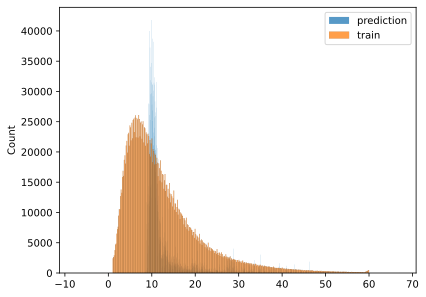

In [30]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='train')
_ = plt.legend()

## Evaluation on val dataset (February data)

7.639501230202583


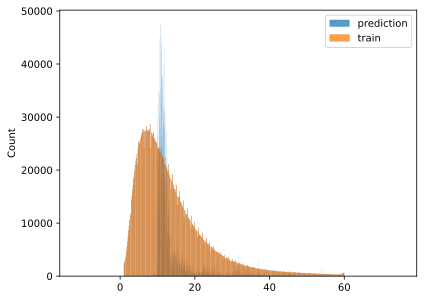

In [32]:
df = pd.read_parquet('../data/yellow_tripdata_2022-02.parquet')
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60.0)
df = df[(df.duration >= 1) & (df.duration <= 60)]
df[categorical] = df[categorical].astype(str)
val_dict = df[categorical].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)
y_val = df[target].values
lr.fit(X_val, y_val)
y_pred = lr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False))

sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='train')
_ = plt.legend()

### Q6: RMSE on Validation dataset
7.63